# Question 1

## Gabor Filters
These are basically units that detect angles in shapes of images, I will be using the OpenCV library to use a pre-implemented version of Gabor Filters to design the cells

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

0,90 is for square and 60,120 are for triangles

In [6]:
def create_kernels(ksize=21, sigma=2, lambd=5, gamma=0.8, psi=0):
    """This a collection of Gabor filters at different orientations to detect multiple angles"""
    orientations = [0, 90,60,120]
    kernels = []
    for theta in orientations:
        theta_rad = np.deg2rad(theta)
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta_rad, lambd, gamma, psi, ktype=cv2.CV_32F)
        kernels.append(kernel)
    return kernels

## Testing on Images

In [7]:
def apply_gabor_filters(image, kernels):
    filtered_images = [cv2.filter2D(image, cv2.CV_8UC3, kernel) for kernel in kernels]
    return np.max(filtered_images, axis=0)  # Combine filtered results

In [8]:
def detect_shapes(image, min_area=500, max_area=50000):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes_detected = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < min_area or area > max_area:  # Ignore very small or very large contours this is done to ignore image boundary and small variations
            continue

        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        # print(approx)
        if len(approx) == 3:
            shape = "Triangle"
        elif len(approx) == 4:
            shape = "Square"
        else:
            shape = "Other"
        shapes_detected.append((shape, approx))

    return shapes_detected


In [9]:
def processing_pipeline(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to grayscale

    gabor_kernels = create_kernels()
    gabor_filtered = apply_gabor_filters(gray, gabor_kernels)

    edges = cv2.Canny(gabor_filtered, 50, 150) # Apply Canny Edge detection for better edge detection
    shapes = detect_shapes(edges)
    # shapes = detect_shapes(gabor_filtered)

    for shape, approx in shapes:
        print(shape)
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 3)
        x, y = approx[0][0]
        cv2.putText(image, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(gray, cmap='gray')
    plt.axis("off")
    plt.title("Grayscale Image")

    plt.subplot(1,4,2)
    plt.imshow(gabor_filtered, cmap='gray')
    plt.axis("off")
    plt.title("Gabor Filtered Image")
    # print(gabor_filtered)

    plt.subplot(1, 4, 3)
    plt.imshow(edges, cmap='gray')
    plt.axis("off")
    plt.title("Canny Edge Detection")

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detected Shapes")

    plt.show()


Triangle


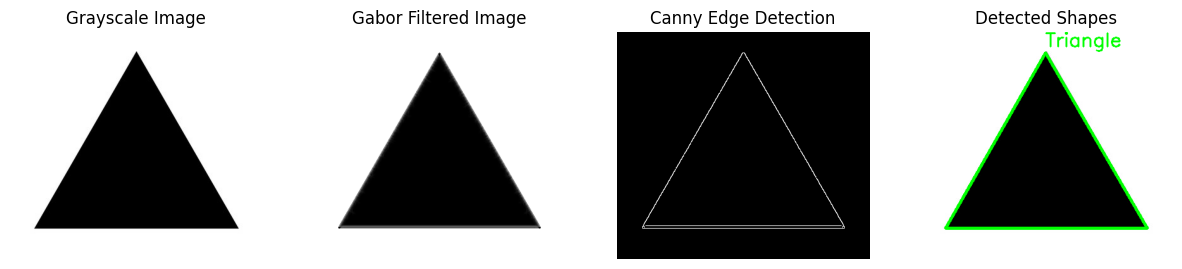

In [10]:
image_path = "/content/black_triangle.jpg" # Replace with your image path
processing_pipeline(image_path)

### Visualization
This a visualization that is helpful in understanding Gabor Filters the code.
<br>Decleration: I took the help of ChatGPT to debug this visualization as this was not part of the assignment and I wanted to understand how Gabor filters worked better

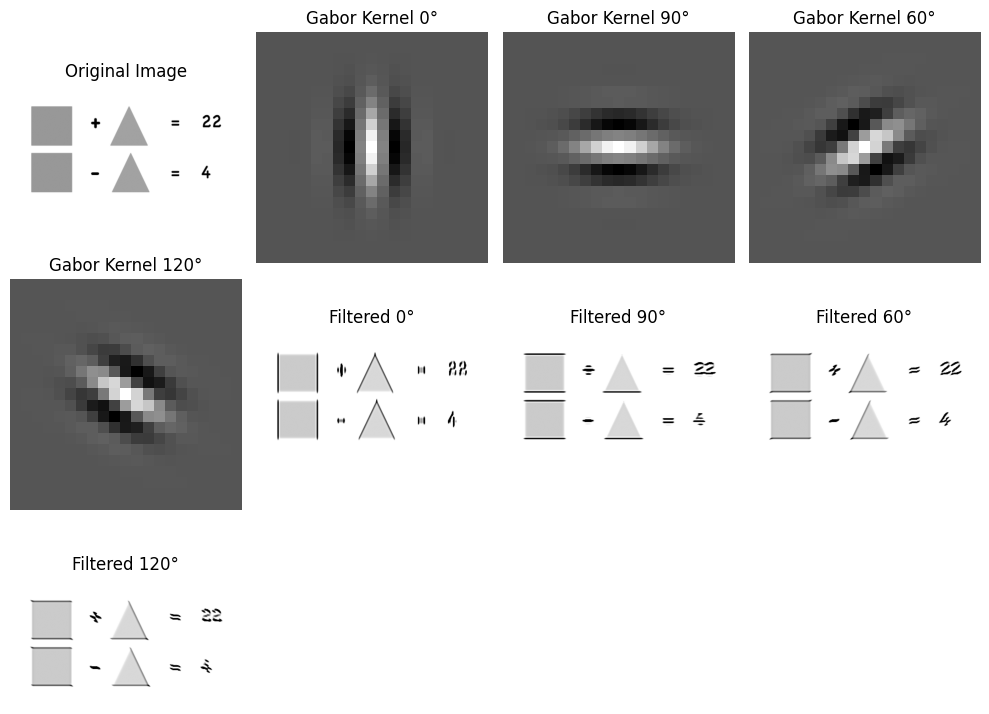

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to create a Gabor filter
def create_gabor_kernel(ksize=21, sigma=2, lambd=5, gamma=0.8, psi=0, theta=0):
    theta_rad = np.deg2rad(theta)  # Convert degrees to radians
    return cv2.getGaborKernel((ksize, ksize), sigma, theta_rad, lambd, gamma, psi, ktype=cv2.CV_32F)

# Apply Gabor filter to image
def apply_gabor_filter_vis(image, kernel):
    gabor_filtered = np.abs(cv2.filter2D(image, cv2.CV_8UC3, kernel))
    gabor_filtered = cv2.normalize(gabor_filtered, None, 0, 255, cv2.NORM_MINMAX)
    gabor_filtered = gabor_filtered.astype(np.uint8)
    return gabor_filtered

# Load image and convert to grayscale
image_path = "/content/square_triangle_question.png"  # Replace with your image file
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Define orientations for Gabor filters
orientations = [0, 90,60,120]  # Degrees
filtered_images = []

# Generate and apply Gabor filters
for theta in orientations:
    kernel = create_gabor_kernel(theta=theta)
    filtered = apply_gabor_filter_vis(gray, kernel)
    filtered_images.append((theta, kernel, filtered))

# Display results
plt.figure(figsize=(10, 8))

# Show original image
plt.subplot(3, len(orientations), 1)
plt.imshow(gray, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Show Gabor filter kernels
for i, (theta, kernel, _) in enumerate(filtered_images):
    plt.subplot(3, len(orientations), i + 2)
    plt.imshow(kernel, cmap='gray')
    plt.title(f"Gabor Kernel {theta}°")
    plt.axis("off")

# Show filtered images
for i, (theta, _, filtered) in enumerate(filtered_images):
    plt.subplot(3, len(orientations), i + len(orientations) + 2)
    plt.imshow(filtered, cmap='gray')
    plt.title(f"Filtered {theta}°")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Question 2

I will define two functions to extract details of different shapes and different colors and then using a pipeline I will get the type of detection required as input and then according to that search for those particular features

## Shapes

In [12]:
def feature_search_shape(image):
    # image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to grayscale

    gabor_kernels = create_kernels()
    gabor_filtered = apply_gabor_filters(gray, gabor_kernels)

    edges = cv2.Canny(gabor_filtered, 50, 150) # Apply Canny Edge detection for better edge detection

    shapes = detect_shapes(edges)

    n_triangles=0
    n_squares=0
    for shape, approx in shapes:
        if shape == "Triangle":
            n_triangles += 1
        elif shape == "Square":
            n_squares += 1

    return n_triangles,n_squares,shapes

    # # Display results
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(gray, cmap='gray')
    # plt.title("Grayscale Image")


    # plt.subplot(1, 2, 2)
    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.title("Searched Shapes")

    # plt.show()

## Colors

In [39]:
def feature_search_color(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # Convert to HSV for ranges as HSV better represents human perception

    lower_red1 = np.array([0, 120, 70])     # First red range
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])   # Second red range
    upper_red2 = np.array([180, 255, 255])

    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])

    red_mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    red_mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    red_mask = red_mask1 + red_mask2  # Combine both red masks
    blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

    red_objects = cv2.bitwise_and(image, image, mask=red_mask)
    blue_objects = cv2.bitwise_and(image, image, mask=blue_mask)

    # plt.imshow(cv2.cvtColor(red_objects, cv2.COLOR_BGR2RGB))
    # plt.title("Red Objects")
    # plt.axis("off")
    # plt.show()

    # plt.imshow(cv2.cvtColor(blue_objects, cv2.COLOR_BGR2RGB))
    # plt.title("Blue Objects")
    # plt.axis("off")
    # plt.show()

    return red_mask,blue_mask,red_objects, blue_objects

## Pipelining
This is the main driver code, with self explenatory variable names, this part requires user input and is just a basic if-else branching based on what the user wants

In [40]:
def processing_pipeline2(image_path,type_of_search=None,type_of_feature=None,type_of_shape=None,type_of_color=None):
    image = cv2.imread(image_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Original Image")

    if type_of_search == None:
        type_of_search = input("What is the type of search? Write C for conjuction and F for feature: ")
    if type_of_search == 'F':
        if type_of_feature == None:
            type_of_feature = input("What feature would you like to search for? Write S for shape and C for color: ")
        if type_of_feature == 'S':
            triangle_search = False
            square_search = False
            if type_of_shape == None:
                type_of_shape = input("What is the shape you want to search for? Write S for sqaure and T for triangle: ")
            if type_of_shape == 'S':
                square_search = True
            elif type_of_shape == 'T':
                triangle_search = True
            _,_,shapes = feature_search_shape(image)
            for shape, approx in shapes:
                # print(shape)
                if shape == "Triangle" and triangle_search:
                    pass
                elif shape == "Square" and square_search:
                    pass
                else:
                    continue
                cv2.drawContours(image, [approx], -1, (0, 255, 0), 3)
                x, y = approx[0][0]
                cv2.putText(image, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title("Feature Search for Shape")
        elif type_of_feature == "C":
            red_search = False
            blue_search = False
            if type_of_color == None:
                type_of_color = input("What is the color you want to search for? Write R for red and B for blue: ")
            _,_,red_objects, blue_objects = feature_search_color(image)
            if type_of_color == 'R':
                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(red_objects, cv2.COLOR_BGR2RGB))
                plt.axis("off")
                plt.title("Feature Search for Color")
            elif type_of_color == 'B':
                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(blue_objects, cv2.COLOR_BGR2RGB))
                plt.axis("off")
                plt.title("Feature Search for Color")
    elif type_of_search == 'C':
        if type_of_color == None:
            type_of_color = input("What is the color you want to search for? Write R for red and B for blue: ")
        if type_of_shape == None:
            type_of_shape = input("What is the shape you want to search for? Write S for sqaure and T for triangle: ")
        _,_,red_objects, blue_objects = feature_search_color(image)
        color_image = None
        if type_of_color == 'R':
            color_image = red_objects
        elif type_of_color == 'B':
            color_image = blue_objects
        _,_,shapes = feature_search_shape(color_image)
        triangle_search = False
        square_search = False
        if type_of_shape == 'S':
            square_search = True
        elif type_of_shape == 'T':
            triangle_search = True
        for shape, approx in shapes:
            # print(shape)
            if shape == "Triangle" and triangle_search:
                pass
            elif shape == "Square" and square_search:
                pass
            else:
                continue
            cv2.drawContours(image, [approx], -1, (0, 255, 0), 3)
            x, y = approx[0][0]
            cv2.putText(image, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Conjunction Search")

    else:
        print("Enter a valid letter")

    plt.show()

What is the type of search? Write C for conjuction and F for feature: C
What is the color you want to search for? Write R for red and B for blue: R
What is the shape you want to search for? Write S for sqaure and T for triangle: T


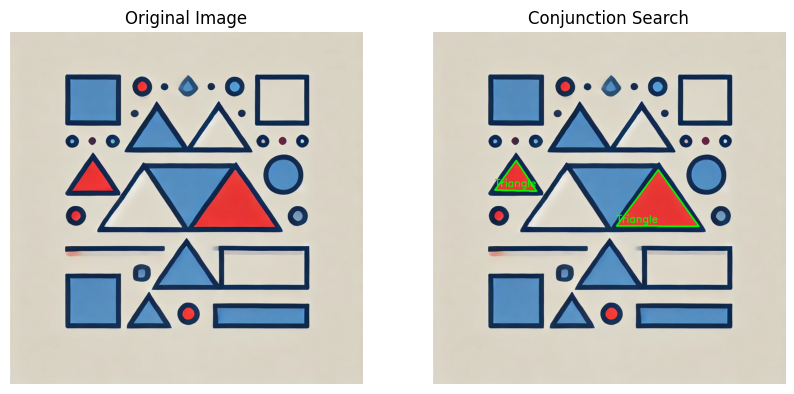

In [41]:
image_path = "/content/triangles_squares_blue_red.webp" # Modify to path of required image
processing_pipeline2(image_path)

# Generating Images for Testing
I am generating random images containing triangles and squares for this part as this is needed to draw graphs for the next part

In [1]:
import random

In [2]:
def draw_shape(image, shape, color, position, size=30):
    """Draws a triangle or square on the image."""
    x, y = position
    if shape == "square":
        cv2.rectangle(image, (x, y), (x + size, y + size), color, -1)
    elif shape == "triangle":
        pts = np.array([[x, y + size], [x + size // 2, y], [x + size, y + size]], np.int32)
        cv2.fillPoly(image, [pts], color)


In [3]:
def generate_visual_search_image(num_red_triangles, num_red_squares, num_blue_triangles, num_blue_squares):

    img_size = 1000
    image = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255  # White background

    colors = [(255, 0, 0), (0, 0, 255)]  # Red, Blue (in BGR format)
    shapes = ["triangle", "square"]

    num_objects = num_red_triangles + num_red_squares + num_blue_triangles + num_blue_squares

    # Generate random positions
    positions = set()
    while len(positions) < num_objects:
        x, y = random.randint(50, img_size - 50), random.randint(50, img_size - 50)
        positions.add((x, y))

    # Draw all objects
    positions = list(positions)

    list_of_shapes = [num_red_triangles,num_red_squares,num_blue_triangles,num_blue_squares]

    for i, pos in enumerate(positions):
        index = random.randint(0,3)
        while list_of_shapes[index] == 0:
            index = random.randint(0,3)
        list_of_shapes[index] -= 1
        curr_color = colors[index % 2]
        curr_shape = shapes[index // 2]

        draw_shape(image, curr_shape, curr_color, pos)

    return image

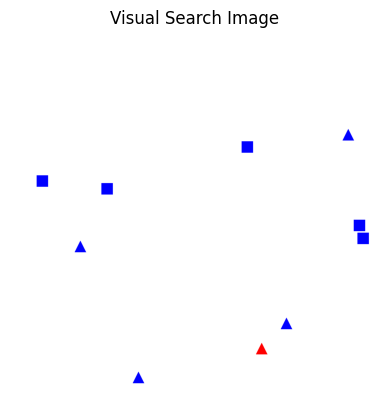

In [16]:
# Testing
image = generate_visual_search_image(4, 1, 5, 0)

# Display the generated image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Visual Search Image")
plt.show()

# Question 3

In [17]:
import time

In this section I have set the processing delay to 10ms arbitrarily

## Feature Search
I will draw the graph of how feature search time changes with increase in the total number of objects, here the feature to be searched will be a square in a set of triangles

In [42]:
def feature_data_point(num_objects,processing_delay=0.01):
    image = generate_visual_search_image(num_objects-1,1,0,0)
    start_time = time.time()
    _,_,shapes = feature_search_shape(image)

    square_exists = False
    for shape, approx in shapes:
        if shape == "Square":
            square_exists = True
            break
    time.sleep(processing_delay)

    end_time = time.time()
    return end_time - start_time

In [43]:
def draw_feature_graph(max_objects=100,processing_delay=0.01,n_shots = 10):
    x_values = list(range(1, max_objects + 1))
    y_values = []
    for num_objects in x_values:
        time = 0
        for shot in range(n_shots):
            # shots added to get a better estimate on the runtime
            time += feature_data_point(num_objects,processing_delay)
        y_values.append(time/n_shots)
    # y_values = [feature_data_point(num_objects,processing_delay) for num_objects in x_values]
    plt.plot(x_values, y_values, marker='o')
    plt.xlabel('Number of Objects')
    plt.ylabel('Time (seconds)')
    plt.title('Feature Search Time vs. Number of Objects')
    plt.grid(True)
    plt.show()

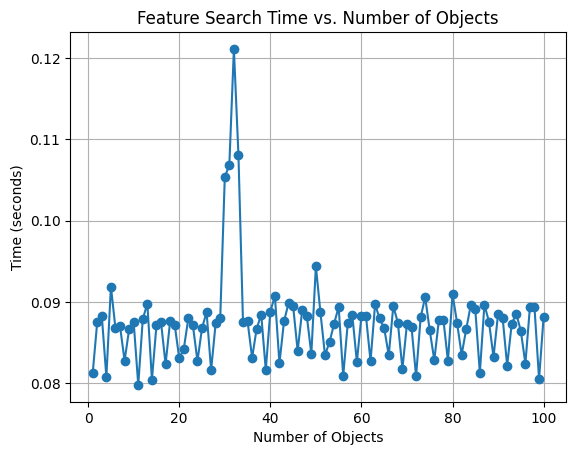

In [44]:
processing_delay = 0.01 # 10ms delay adjust as required
max_objects = 100 # range of graph
n_shots = 100 # number of times each value is run
draw_feature_graph(max_objects,processing_delay,n_shots)

As can be seen the graph is more or less constant with a few irregularities which can be due to irregularities in the shapes produced

## Conjunction Search
I will draw the graph of how conjunction search time changes with increase in the total number of objects, here the feature to be searched will be a blue square in a set of triangles of both colors and red squares

In [45]:
def conjunction_data_point(num_objects,processing_delay=0.01):
    triangles = random.randint(1,num_objects - 1)
    red_triangles = random.randint(0,triangles)
    blue_triangles = triangles - red_triangles
    squares = num_objects - triangles
    image = generate_visual_search_image(red_triangles,squares-1,blue_triangles,1)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    start_time = time.time()
    red_mask,blue_mask,red_objects, blue_objects = feature_search_color(image)
    _,_,shapes = feature_search_shape(image)
    # _,_,blue_shapes = feature_search_shape(blue_objects)


    blue_square_exists = False
    for shape, approx in shapes:
        time.sleep(processing_delay)
        if shape == "Square":
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.drawContours(mask, [approx[0]], -1, (255), thickness=cv2.FILLED)
            mean_color = cv2.mean(hsv_image, mask=mask)
            if mean_color[0] >=90 and mean_color[0] <= 130:
                blue_square_exists = True
                break

    end_time = time.time()
    return end_time - start_time

In [46]:
def draw_conjunction_graph(max_objects=100,processing_delay=0.01,n_shots = 100):
    x_values = list(range(3, max_objects + 1))
    y_values = []
    for num_objects in x_values:
        print("Executing num_objects = "+ num_objects)
        time = 0
        for shot in range(n_shots):
            time += conjunction_data_point(num_objects,processing_delay)
        y_values.append(time/n_shots)

    plt.plot(x_values, y_values, marker='o')
    plt.xlabel('Number of Objects')
    plt.ylabel('Time (seconds)')
    plt.title('Conjunction Search Time vs. Number of Objects')
    plt.grid(True)
    plt.show()

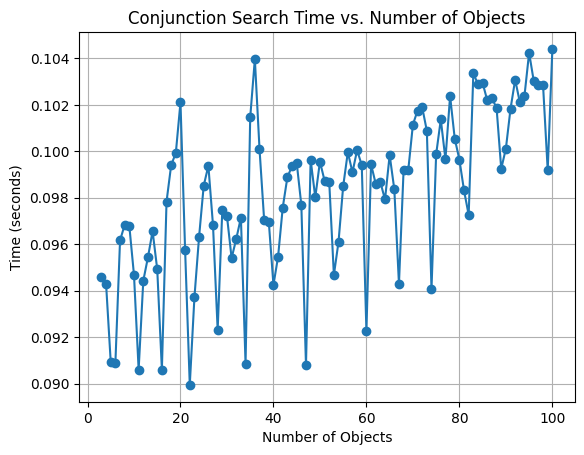

In [47]:
processing_delay = 0.01 # 10ms delay adjust as required
max_objects = 100 # range of graph
n_shots = 100 # number of times each value is run
draw_conjunction_graph(max_objects,processing_delay,n_shots)

As can be seen the graph is mostly increasing with a few irregularities which are most likely due to different kind of images produces due to the randomization in number of shapes. For better normalization here more shots would be required but due to time constraints I am restricting them